In [76]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import date_to_unix as date
import datetime
import itertools

In [77]:

# Initialize the Binance client
client = Client()

In [78]:
# UNIX timestamp 
start_date = date.date_to_unix('2019-09-10 00:00:00')


In [79]:


# UNIX timestamp for today's midnight
today_midnight = datetime.datetime.combine(datetime.date.today(), datetime.time())

today_midnight_unix = date.date_to_unix(today_midnight.strftime('%Y-%m-%d %H:%M:%S'))

all_funding_df = pd.DataFrame()
funding_df=pd.DataFrame()
funding_rates = []

while True:
    # Query the futures funding rates
    funding_rates = client.futures_funding_rate(symbol='BTCUSDT', startTime = start_date, limit=1000)

    # Convert to DataFrame
    funding_df = pd.DataFrame(funding_rates)
    funding_df['fundingTime'] = pd.to_datetime(funding_df['fundingTime'], unit='ms').dt.round('s')
    funding_df.set_index('fundingTime', inplace=True)
    
    # Concatenate the newly fetched data with the accumulated data
    all_funding_df = pd.concat([all_funding_df, funding_df])

    # Get the last date in the fetched data
    last_date = funding_df.index[-1]

    if last_date >= pd.to_datetime(today_midnight_unix, unit='s'):
        break
    else:
        # Set start_date to the last fetched timestamp in UNIX format for the next query iteration
        start_date = int(last_date.timestamp() * 1000)  # Convert to milliseconds for Binance API

# You now have your data collected in funding_df up to today's midnight
print(all_funding_df)
print(funding_rates)

                      symbol  fundingRate       markPrice
fundingTime                                              
2019-09-10 08:00:00  BTCUSDT   0.00010000                
2019-09-10 16:00:00  BTCUSDT   0.00010000                
2019-09-11 00:00:00  BTCUSDT   0.00010000                
2019-09-11 08:00:00  BTCUSDT   0.00010000                
2019-09-11 16:00:00  BTCUSDT   0.00010000                
...                      ...          ...             ...
2024-05-15 00:00:00  BTCUSDT   0.00010000  61551.95992663
2024-05-15 08:00:00  BTCUSDT  -0.00000385  62161.81007092
2024-05-15 16:00:00  BTCUSDT   0.00002373  64699.90000000
2024-05-16 00:00:00  BTCUSDT   0.00002103  66176.31760993
2024-05-16 08:00:00  BTCUSDT   0.00005148  66106.70102128

[5136 rows x 3 columns]
[{'symbol': 'BTCUSDT', 'fundingTime': 1711958400000, 'fundingRate': '0.00033491', 'markPrice': '69636.12130851'}, {'symbol': 'BTCUSDT', 'fundingTime': 1711987200000, 'fundingRate': '0.00027469', 'markPrice': '68284.830751

In [80]:
funding_df= all_funding_df

print(funding_df.shape)
print(funding_df.dtypes)

(5136, 3)
symbol         object
fundingRate    object
markPrice      object
dtype: object


In [81]:
#Give correct type
funding_df['fundingRate'] = funding_df['fundingRate'].astype(float)
funding_df['symbol'] = funding_df['symbol'].astype(str)
funding_df['markPrice'] = pd.to_numeric(funding_df['markPrice'], errors='coerce')
print(funding_df.head())
print(funding_df.tail())
print(funding_df.describe())


                      symbol  fundingRate  markPrice
fundingTime                                         
2019-09-10 08:00:00  BTCUSDT       0.0001        NaN
2019-09-10 16:00:00  BTCUSDT       0.0001        NaN
2019-09-11 00:00:00  BTCUSDT       0.0001        NaN
2019-09-11 08:00:00  BTCUSDT       0.0001        NaN
2019-09-11 16:00:00  BTCUSDT       0.0001        NaN
                      symbol  fundingRate     markPrice
fundingTime                                            
2024-05-15 00:00:00  BTCUSDT     0.000100  61551.959927
2024-05-15 08:00:00  BTCUSDT    -0.000004  62161.810071
2024-05-15 16:00:00  BTCUSDT     0.000024  64699.900000
2024-05-16 00:00:00  BTCUSDT     0.000021  66176.317610
2024-05-16 08:00:00  BTCUSDT     0.000051  66106.701021
       fundingRate     markPrice
count  5136.000000    596.000000
mean      0.000134  51658.085535
std       0.000244  12214.958562
min      -0.003000  34149.463652
25%       0.000043  42014.225000
50%       0.000100  46265.417668
75%   

In [82]:
# Fetch historical price data for BTCUSDT spot and future
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_8HOUR, funding_df.index[0].strftime('%Y-%m-%d %H:%M:%S'))
klines_future= client.futures_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_8HOUR, funding_df.index[0].strftime('%Y-%m-%d %H:%M:%S'))

In [83]:
def klines_toDf(klines):
    """
    Convert list of klines to a pandas DataFrame.

    :param klines: A list of klines data.
    :type klines: list
    :return: A pandas DataFrame with columns ['Open Time', 'Open', 'Close', 'Volume'].
    :rtype: pandas.DataFrame
    """
    prices_df = pd.DataFrame(klines, columns=[
        'Open Time', 
        'Open', 
        'High', 
        'Low', 
        'Close', 
        'Volume', 
        'Close Time', 
        'Quote Asset Volume', 
        'Number of Trades', 
        'Taker Buy Base Asset Volume', 
        'Taker Buy Quote Asset Volume', 
        'Ignore'
    ])
    
    prices_df = prices_df[['Open Time', 'Open', 'Close', 'Volume']]
    
    # Convert time from milliseconds to a readable date format
    prices_df['Open Time'] = pd.to_datetime(prices_df['Open Time'], unit='ms')
    prices_df.set_index('Open Time', inplace=True)
    # Convert 'Open', 'Close', and 'Volume' to float
    prices_df['Open'] = prices_df['Open'].astype(float)
    prices_df['Close'] = prices_df['Close'].astype(float)
    prices_df['Volume'] = prices_df['Volume'].astype(float)
    
    # Now apply rounding
    prices_df = prices_df.round(decimals=4)
    
    # Check the changes
    print(prices_df.head())
    print(prices_df.tail())
    print(prices_df.dtypes)
    print(prices_df.shape)
    return prices_df

In [84]:
# Convert the spot and future kline data to dataframes
price_df_spot = klines_toDf(klines)
price_df_futur = klines_toDf(klines_future)

# Rename the 'Open' column in both dataframes for clarity
price_df_spot = price_df_spot.rename(columns={'Open': 'Open BTCUSDT_SPOT'})
price_df_futur = price_df_futur.rename(columns={'Open': 'Open BTCUSDT_PERP'})

# Concatenate the two dataframes along the column axis
prices_df = pd.concat([price_df_spot['Open BTCUSDT_SPOT'], price_df_spot['Volume'], price_df_futur['Open BTCUSDT_PERP'], price_df_futur['Volume']], axis=1)
prices_df.columns = ['Open BTCUSDT_SPOT', 'Volume BTC_SPOT', 'Open BTCUSDT_PERP', 'Volume BTC_PERP']
# Display the resulting dataframe
prices_df

                         Open     Close      Volume
Open Time                                          
2019-09-10 08:00:00  10272.64  10175.07   8525.1546
2019-09-10 16:00:00  10176.26  10098.15  12837.4118
2019-09-11 00:00:00  10098.19  10066.00  13242.1083
2019-09-11 08:00:00  10066.38   9990.07   9300.9061
2019-09-11 16:00:00   9990.57  10158.33   9410.8103
                         Open     Close      Volume
Open Time                                          
2024-05-15 00:00:00  61577.49  62195.04   4651.4868
2024-05-15 08:00:00  62195.04  64725.11  24324.6197
2024-05-15 16:00:00  64725.12  66206.50  14583.6407
2024-05-16 00:00:00  66206.51  66142.62   8084.9442
2024-05-16 08:00:00  66142.62  65708.01  11264.8654
Open      float64
Close     float64
Volume    float64
dtype: object
(5131, 3)
                         Open     Close    Volume
Open Time                                        
2019-09-10 08:00:00  10271.93  10179.10  2938.811
2019-09-10 16:00:00  10172.13  10102.02  287

,Open BTCUSDT_SPOT,Volume BTC_SPOT,Open BTCUSDT_PERP,Volume BTC_PERP
Open Time,,,,
2019-09-10 08:00:00,10272.64,8525.1546,10271.93,2938.811
2019-09-10 16:00:00,10176.26,12837.4118,10172.13,2876.606
2019-09-11 00:00:00,10098.19,13242.1083,10094.27,2794.485
2019-09-11 08:00:00,10066.38,9300.9061,10068.41,2857.850
2019-09-11 16:00:00,9990.57,9410.8103,9992.18,5245.587
...,...,...,...,...
2024-05-15 00:00:00,61577.49,4651.4868,61550.50,38946.562
2024-05-15 08:00:00,62195.04,24324.6197,62157.50,209926.961
2024-05-15 16:00:00,64725.12,14583.6407,64685.40,116158.157


In [85]:
#Merge the prices with the funding and Mark price
data2 = pd.concat([prices_df,funding_df['fundingRate'],funding_df['markPrice']],axis=1)
data2['cumulative funding rate'] = data2['fundingRate'].cumsum()
data2.index.name = 'Open Time'

In [86]:
data2.shape

(5136, 7)

In [87]:
data2.tail()


,Open BTCUSDT_SPOT,Volume BTC_SPOT,Open BTCUSDT_PERP,Volume BTC_PERP,fundingRate,markPrice,cumulative funding rate
Open Time,,,,,,,
2024-05-15 00:00:00,61577.49,4651.4868,61550.5,38946.562,0.000100,61551.959927,0.689048
2024-05-15 08:00:00,62195.04,24324.6197,62157.5,209926.961,-0.000004,62161.810071,0.689044
2024-05-15 16:00:00,64725.12,14583.6407,64685.4,116158.157,0.000024,64699.900000,0.689068
2024-05-16 00:00:00,66206.51,8084.9442,66175.4,54575.010,0.000021,66176.317610,0.689089
2024-05-16 08:00:00,66142.62,11264.8654,66100.0,101070.098,0.000051,66106.701021,0.689140


In [88]:
data2.describe()

,Open BTCUSDT_SPOT,Volume BTC_SPOT,Open BTCUSDT_PERP,Volume BTC_PERP,fundingRate,markPrice,cumulative funding rate
count,5136.000000,5136.000000,5136.000000,5.136000e+03,5136.000000,596.000000,5136.000000
mean,29758.669011,29682.342905,29760.348322,1.228582e+05,0.000134,51658.085535,0.399313
std,17174.374972,32971.702743,17183.575938,9.604969e+04,0.000244,12214.958562,0.211942
min,4789.990000,2079.707700,4762.280000,1.081400e+01,-0.003000,34149.463652,0.000100
25%,15587.497500,11371.390625,15596.792500,5.944728e+04,0.000043,42014.225000,0.157321
50%,27572.560000,18125.531550,27557.950000,9.695333e+04,0.000100,46265.417668,0.504905
75%,42442.997500,32463.099800,42434.360000,1.561888e+05,0.000100,63928.248447,0.561211
max,73224.000000,377454.007400,73280.700000,1.324521e+06,0.003000,73280.700000,0.689140


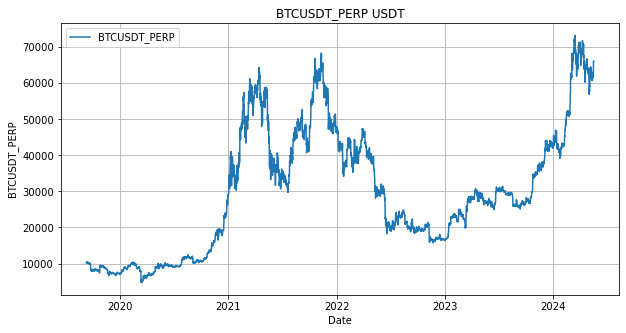

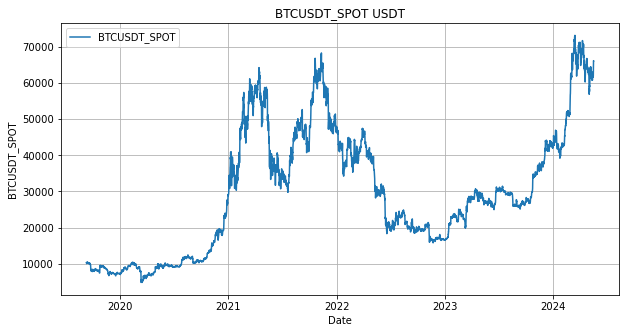

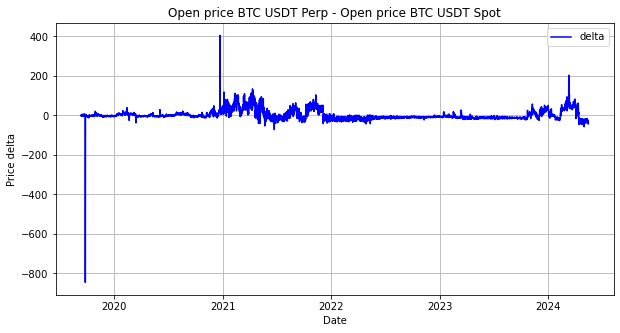

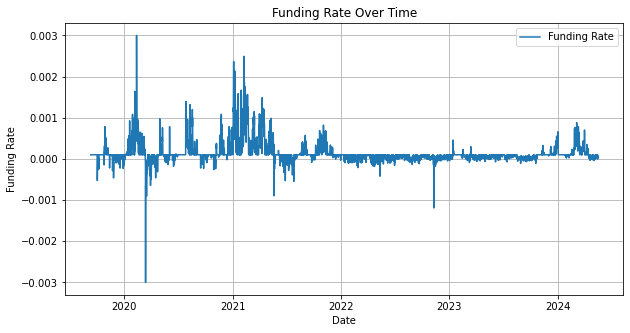

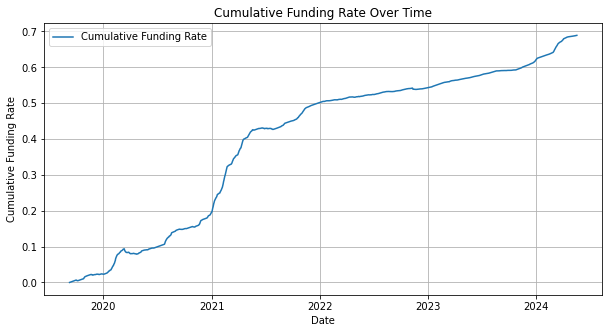

In [89]:
# Plotting BTCUSDT_PERP prices
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['Open BTCUSDT_PERP'],label = 'BTCUSDT_PERP')
plt.title('BTCUSDT_PERP USDT')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('BTCUSDT_PERP')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

# Plotting BTCUSDT_SPOT prices
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['Open BTCUSDT_SPOT'],label = 'BTCUSDT_SPOT')
plt.title('BTCUSDT_SPOT USDT')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('BTCUSDT_SPOT')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

#Plotting the price difference between Future and Spot on Binance perpetual 
plt.figure(figsize=(10, 5))
plt.plot(prices_df.index, prices_df['Open BTCUSDT_PERP']-prices_df['Open BTCUSDT_SPOT'], color='blue', label= 'delta')
plt.title('Open price BTC USDT Perp - Open price BTC USDT Spot')
plt.xlabel('Date')
plt.ylabel('Price delta')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the funding rate
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['fundingRate'], label='Funding Rate')
plt.title('Funding Rate Over Time')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Funding Rate')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend if necessary
plt.show()  # Display the plot

# Plotting the cumulative funding rate
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(data2.index, data2['cumulative funding rate'], label='Cumulative Funding Rate')
plt.title('Cumulative Funding Rate Over Time')  # Title of the plot
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Cumulative Funding Rate')  # Label for the y-axis
plt.grid(True)  # Add gridlines for better readability
plt.legend()  # Add a legend
plt.show()  # Display the plot


In [90]:
data2

,Open BTCUSDT_SPOT,Volume BTC_SPOT,Open BTCUSDT_PERP,Volume BTC_PERP,fundingRate,markPrice,cumulative funding rate
Open Time,,,,,,,
2019-09-10 08:00:00,10272.64,8525.1546,10271.93,2938.811,0.000100,NaN,0.000100
2019-09-10 16:00:00,10176.26,12837.4118,10172.13,2876.606,0.000100,NaN,0.000200
2019-09-11 00:00:00,10098.19,13242.1083,10094.27,2794.485,0.000100,NaN,0.000300
2019-09-11 08:00:00,10066.38,9300.9061,10068.41,2857.850,0.000100,NaN,0.000400
2019-09-11 16:00:00,9990.57,9410.8103,9992.18,5245.587,0.000100,NaN,0.000500
...,...,...,...,...,...,...,...
2024-05-15 00:00:00,61577.49,4651.4868,61550.50,38946.562,0.000100,61551.959927,0.689048
2024-05-15 08:00:00,62195.04,24324.6197,62157.50,209926.961,-0.000004,62161.810071,0.689044
2024-05-15 16:00:00,64725.12,14583.6407,64685.40,116158.157,0.000024,64699.900000,0.689068


In [91]:
data2.to_csv('data\Bitcoin 2019-09-10')

In [93]:
# Calculate the correlation matrix
correlation_matrix = data2[['Volume BTC_SPOT', 'Volume BTC_PERP', 'fundingRate']].corr()

# Print the correlation matrix
print(correlation_matrix)

                 Volume BTC_SPOT  Volume BTC_PERP  fundingRate
Volume BTC_SPOT         1.000000         0.705233    -0.072571
Volume BTC_PERP         0.705233         1.000000    -0.094338
fundingRate            -0.072571        -0.094338     1.000000


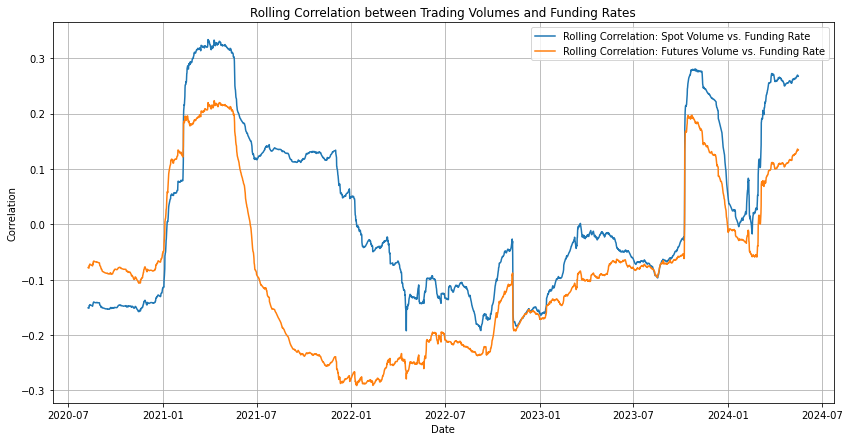

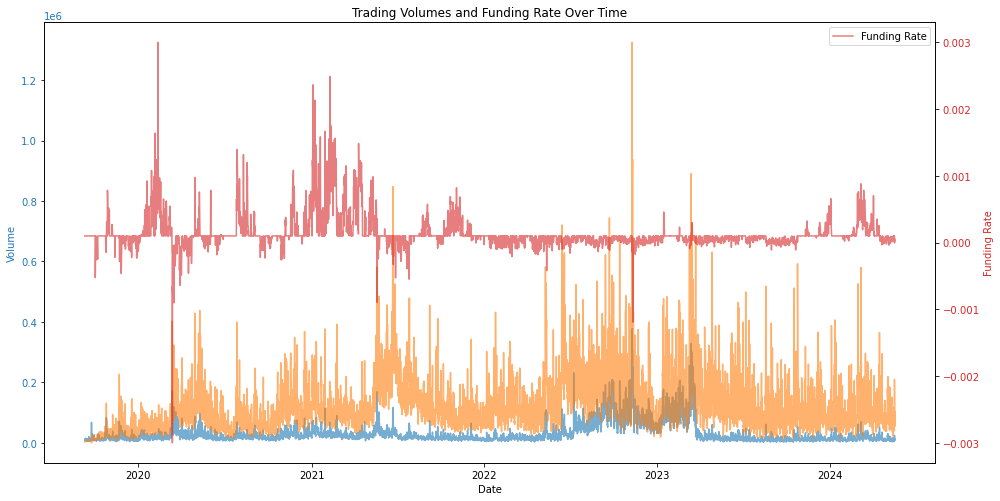

In [104]:
# Calculate rolling correlation (e.g., 30-period window)
data2['rolling_corr_spot'] = data2['Volume BTC_SPOT'].rolling(window=1000).corr(data2['fundingRate'])
data2['rolling_corr_perp'] = data2['Volume BTC_PERP'].rolling(window=1000).corr(data2['fundingRate'])

# Plot the rolling correlations
plt.figure(figsize=(14, 7))
plt.plot(data2.index, data2['rolling_corr_spot'], label='Rolling Correlation: Spot Volume vs. Funding Rate')
plt.plot(data2.index, data2['rolling_corr_perp'], label='Rolling Correlation: Futures Volume vs. Funding Rate')
plt.legend()
plt.title('Rolling Correlation between Trading Volumes and Funding Rates')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

# Plot the time-series data for visual inspection
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Volume', color='tab:blue')
ax1.plot(data2.index, data2['Volume BTC_SPOT'], label='Spot Volume', color='tab:blue', alpha=0.6)
ax1.plot(data2.index, data2['Volume BTC_PERP'], label='Futures Volume', color='tab:orange', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Funding Rate', color='tab:red')
ax2.plot(data2.index, data2['fundingRate'], label='Funding Rate', color='tab:red', alpha=0.6)
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Trading Volumes and Funding Rate Over Time')
plt.legend()
plt.show()

In [100]:
print(data2.head())

# Check for missing values
missing_values = data2.isna().sum()
print("Missing values per column:\n", missing_values)

# Check data types
print("Data types:\n", data2.dtypes)

# Verify ranges of key columns
price_columns = ['Open BTCUSDT_SPOT', 'Open BTCUSDT_PERP', 'markPrice']
for col in price_columns:
    if (data2[col] <= 0).any():
        print(f"Warning: Column '{col}' contains non-positive values.")
    else:
        print(f"Column '{col}' values are within expected range.")

# Check typical funding rate range (-0.1 to 0.1 for example)
funding_rate_range = (-0.1, 0.1)
if not funding_rate_range[0] <= data2['fundingRate'].min() <= funding_rate_range[1] or not funding_rate_range[0] <= data2['fundingRate'].max() <= funding_rate_range[1]:
    print("Warning: 'fundingRate' values are outside the typical range.")
else:
    print("'fundingRate' values are within the typical range.")
    print("Missing values per column:\n", missing_values)


# Cross-reference a sample of data with historical data (manual step)
# You may manually check the first few rows with data from Binance or a reliable data provider

                     Open BTCUSDT_SPOT  Volume BTC_SPOT  Open BTCUSDT_PERP  \
Open Time                                                                    
2019-09-10 08:00:00           10272.64        8525.1546           10271.93   
2019-09-10 16:00:00           10176.26       12837.4118           10172.13   
2019-09-11 00:00:00           10098.19       13242.1083           10094.27   
2019-09-11 08:00:00           10066.38        9300.9061           10068.41   
2019-09-11 16:00:00            9990.57        9410.8103            9992.18   

                     Volume BTC_PERP  fundingRate  markPrice  \
Open Time                                                      
2019-09-10 08:00:00         2938.811       0.0001        NaN   
2019-09-10 16:00:00         2876.606       0.0001        NaN   
2019-09-11 00:00:00         2794.485       0.0001        NaN   
2019-09-11 08:00:00         2857.850       0.0001        NaN   
2019-09-11 16:00:00         5245.587       0.0001        NaN   

    

In [101]:
print(data2.tail())

                     Open BTCUSDT_SPOT  Volume BTC_SPOT  Open BTCUSDT_PERP  \
Open Time                                                                    
2024-05-15 00:00:00           61577.49        4651.4868            61550.5   
2024-05-15 08:00:00           62195.04       24324.6197            62157.5   
2024-05-15 16:00:00           64725.12       14583.6407            64685.4   
2024-05-16 00:00:00           66206.51        8084.9442            66175.4   
2024-05-16 08:00:00           66142.62       11264.8654            66100.0   

                     Volume BTC_PERP  fundingRate     markPrice  \
Open Time                                                         
2024-05-15 00:00:00        38946.562     0.000100  61551.959927   
2024-05-15 08:00:00       209926.961    -0.000004  62161.810071   
2024-05-15 16:00:00       116158.157     0.000024  64699.900000   
2024-05-16 00:00:00        54575.010     0.000021  66176.317610   
2024-05-16 08:00:00       101070.098     0.000051  

                     Open BTCUSDT_SPOT  Volume BTC_SPOT  Open BTCUSDT_PERP  \
Open Time                                                                    
2019-09-10 08:00:00           10272.64        8525.1546           10271.93   
2019-09-10 16:00:00           10176.26       12837.4118           10172.13   
2019-09-11 00:00:00           10098.19       13242.1083           10094.27   
2019-09-11 08:00:00           10066.38        9300.9061           10068.41   
2019-09-11 16:00:00            9990.57        9410.8103            9992.18   

                     Volume BTC_PERP  fundingRate  markPrice  \
Open Time                                                      
2019-09-10 08:00:00         2938.811       0.0001        NaN   
2019-09-10 16:00:00         2876.606       0.0001        NaN   
2019-09-11 00:00:00         2794.485       0.0001        NaN   
2019-09-11 08:00:00         2857.850       0.0001        NaN   
2019-09-11 16:00:00         5245.587       0.0001        NaN   

    

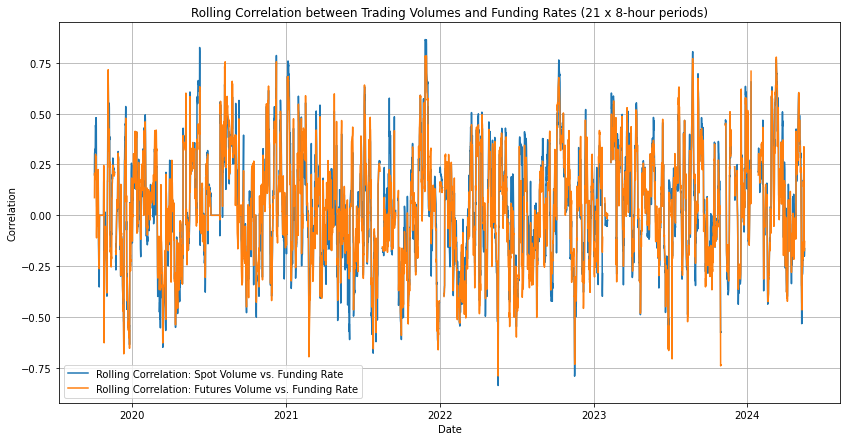

In [106]:
# Assuming 'data2' is already loaded and correctly formatted
# Check the first few rows and columns
print(data2.head())
print(data2.columns)
print(data2.dtypes)

# Define the window size (e.g., 21 periods for a 1-week window)
# For example, 21 periods represent 21 * 8 hours = 168 hours = 1 week
rolling_window_size = 21

# Calculate rolling correlations
data2['rolling_corr_spot'] = data2['Volume BTC_SPOT'].rolling(window=rolling_window_size).corr(data2['fundingRate'])
data2['rolling_corr_perp'] = data2['Volume BTC_PERP'].rolling(window=rolling_window_size).corr(data2['fundingRate'])

# Check for NaN values in the rolling correlation columns
print(data2[['rolling_corr_spot', 'rolling_corr_perp']].head(30))  # Check first 30 rows
print(data2[['rolling_corr_spot', 'rolling_corr_perp']].tail(30))  # Check last 30 rows

# Plot the rolling correlations
plt.figure(figsize=(14, 7))
plt.plot(data2.index, data2['rolling_corr_spot'], label='Rolling Correlation: Spot Volume vs. Funding Rate')
plt.plot(data2.index, data2['rolling_corr_perp'], label='Rolling Correlation: Futures Volume vs. Funding Rate')
plt.legend()
plt.title(f'Rolling Correlation between Trading Volumes and Funding Rates ({rolling_window_size} x 8-hour periods)')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()